<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Adjust-Date-and-Directory-(possibly-via-argument-parser)" data-toc-modified-id="Adjust-Date-and-Directory-(possibly-via-argument-parser)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Adjust Date and Directory (possibly via argument parser)</a></span></li><li><span><a href="#Identfiy-Calibration-and-Science-Runs" data-toc-modified-id="Identfiy-Calibration-and-Science-Runs-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Identfiy Calibration and Science Runs</a></span></li><li><span><a href="#Extract-orders-and-save-in-initial-FITS-files-with-an-extension-per-order." data-toc-modified-id="Extract-orders-and-save-in-initial-FITS-files-with-an-extension-per-order.-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Extract orders and save in initial FITS files with an extension per order.</a></span></li><li><span><a href="#Wavelength-calibration" data-toc-modified-id="Wavelength-calibration-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Wavelength calibration</a></span></li><li><span><a href="#Monitor-RV-(for-stars-with-multiple-observations-and-seperate-reductions)" data-toc-modified-id="Monitor-RV-(for-stars-with-multiple-observations-and-seperate-reductions)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Monitor RV (for stars with multiple observations and seperate reductions)</a></span></li><li><span><a href="#Final-Memory-Check" data-toc-modified-id="Final-Memory-Check-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Final Memory Check</a></span></li></ul></div>

# VeloceReduction -- Tutorial

This tutorial provides an example on how to reduce data of a given night YYMMDD.

In [1]:
# Preamble
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic packages
import numpy as np
from astropy.io import fits
from pathlib import Path
import sys
import argparse

import matplotlib.pyplot as plt

# VeloceReduction modules and function
from VeloceReduction import config
import VeloceReduction as VR

from astropy.table import Table
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from VeloceReduction.utils import get_memory_usage

In [2]:
starting_memory = get_memory_usage()
print('Memory before starting the reduction:')
print(starting_memory)

Memory before starting the reduction:
Run on Apple/Darwin: 1097.1MB


## Adjust Date and Directory (possibly via argument parser)

In [3]:
def parse_arguments():
    # Create the parser
    parser = argparse.ArgumentParser(description="Process some inputs.")
    
    # Add arguments
    parser.add_argument('-d','--date', type=str, default="001122",
                        help='Date in the format DDMMYY (e.g., "001122")')
    parser.add_argument('-wd','--working_directory', type=str, default="./",
                        help='The directory where the script will operate.')
    
    # Parse the arguments
    args = parser.parse_args()
    return args

def get_script_input():
    if 'ipykernel' in sys.modules:
        
        # Assume default values if inside Jupyter
        jupyter_date = "001122"
        
        # 2Amp example
#         jupyter_date = "240219"
        
        # 4Amp example
#         jupyter_date = "231121"


#         jupyter_date = "240201"
#         jupyter_date = "240321"
#         jupyter_date = "240921"
#         jupyter_date = "240919"
#         jupyter_date = "240219"
#         jupyter_date = "250111"
        
        jupyter_working_directory = "./"
        print("Running in a Jupyter notebook. Using predefined values")
        args = argparse.Namespace(date=jupyter_date, working_directory=jupyter_working_directory)
    else:
        # Use argparse to handle command-line arguments
        print("Running as a standalone Python script")
        args = parse_arguments()

    return args

# Use the function to get input
args = get_script_input()
config.date = args.date

if args.working_directory[:2] in ['./','~/']:
    config.working_directory = str(Path(args.working_directory).resolve())+'/'
else:
    config.working_directory = args.working_directory
print(f"Date: {config.date}, Working Directory: {config.working_directory}")

Running in a Jupyter notebook. Using predefined values
Date: 001122, Working Directory: /Users/buder/VeloceReduction/


## Identfiy Calibration and Science Runs

In [4]:
# Extract the Calibration and Science data from the night log
calibration_runs, science_runs = VR.utils.identify_calibration_and_science_runs(
    config.date,
    config.working_directory+'observations/',
    each_science_run_separately = False # Set this True, if you want to reduce the runs of the same object separately
)



Identifying calibration and science runs now

Found Log file /Users/buder/VeloceReduction/observations//001122/001122-AAT-example.log


DarkFrame observations: 1800.0

No Bstar observations identified.

The following science observations were identified: HIP69673


## Extract orders and save in initial FITS files with an extension per order.

Extracting Master Flat
  --> Optimising tramlines based on Flat images (saving at reduced_data/YYMMDD/tramline_information/).
      Check reduced_data/YYMMDD/debug/debug_tramlines_flat.pdf for results.


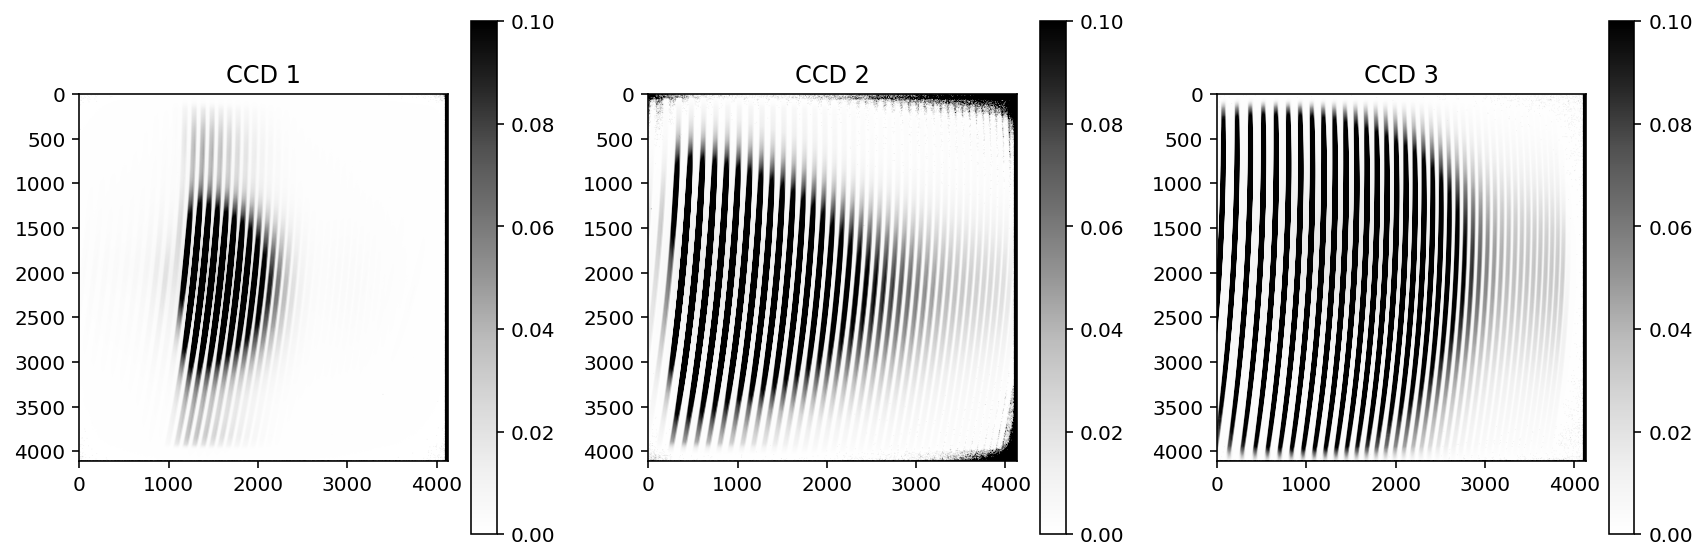

Extracting Master ThXe


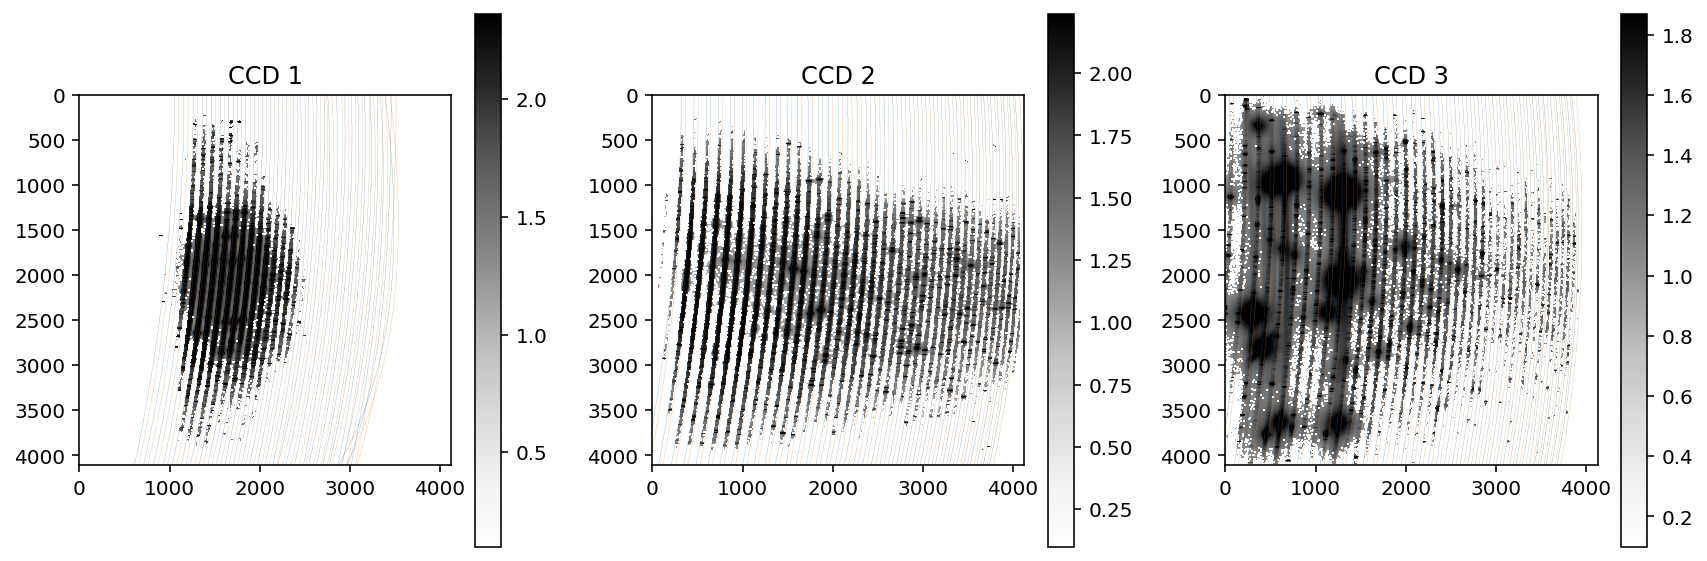

Extracting Master LC


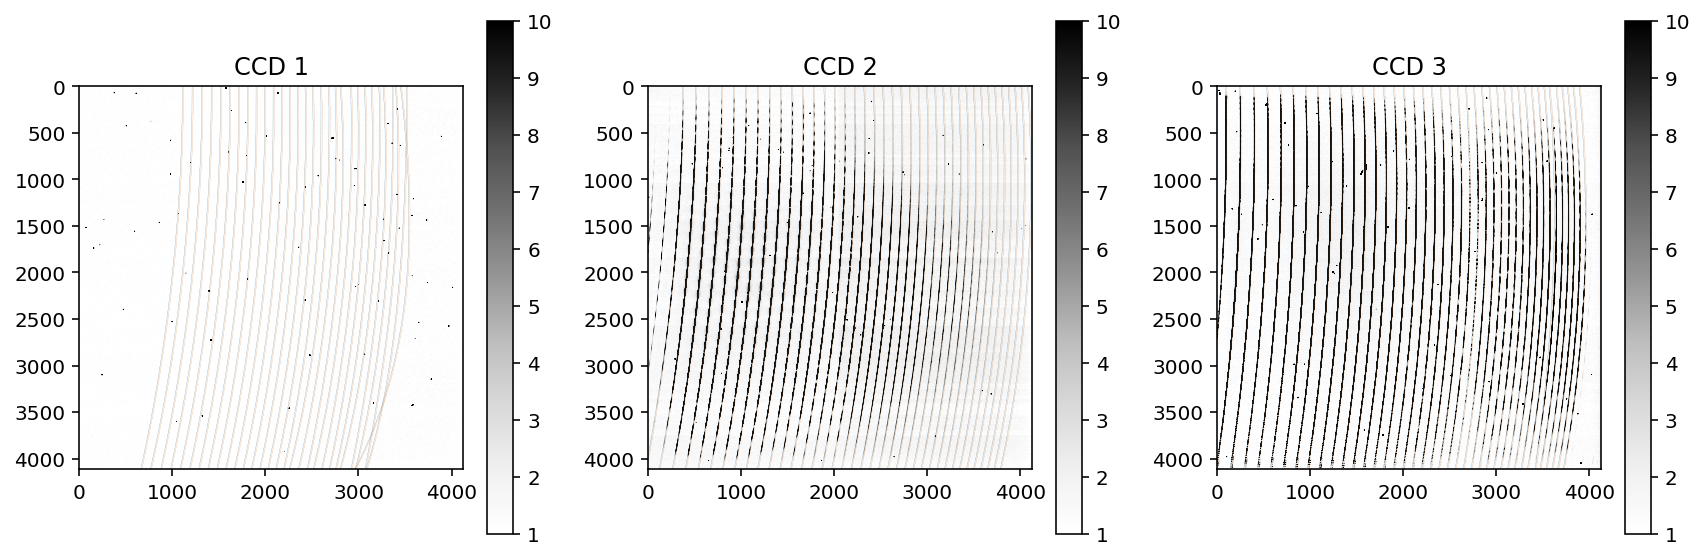

Extracting Darks
  --> 1800.0: 0224,0225,0226


In [5]:
# Extract Master Flat
print('Extracting Master Flat')
master_flat, _ = VR.extraction.extract_orders(
    ccd1_runs = calibration_runs['Flat_60.0'],
    ccd2_runs = calibration_runs['Flat_1.0'],
    ccd3_runs = calibration_runs['Flat_0.1'],
    Flat = True,
    update_tramlines_based_on_flat = True, # Would update and overwrite
    # ./VeloceReduction/tramline_information/tramline_begin_end_ccd_*_oder_*.txt
    debug_overscan = False,
    debug_tramlines = False # Would create a tramlines trace PDF under
    # reduced_data/YYMMDD/debug/debug_tramlines_flat.pdf
)

# Extract Master ThXe
print('Extracting Master ThXe')
master_thxe, _ = VR.extraction.extract_orders(
    ccd1_runs = calibration_runs['FibTh_180.0'][:1],
    ccd2_runs = calibration_runs['FibTh_60.0'][:1],
    ccd3_runs = calibration_runs['FibTh_15.0'][:1],
    ThXe = True,
    debug_tramlines = True # Would create a tramlines trace PDF under
    # reduced_data/YYMMDD/debug/debug_tramlines_thxe.pdf
)

# Extract Master LC
print('Extracting Master LC')
master_lc, _ = VR.extraction.extract_orders(
    ccd1_runs = calibration_runs['SimLC'][-1:],
    ccd2_runs = calibration_runs['SimLC'][-1:],
    ccd3_runs = calibration_runs['SimLC'][-1:],
    LC = True,
    debug_tramlines = True # Would create a tramlines trace PDF under
    # reduced_data/YYMMDD/debug/debug_tramlines_lc.pdf
)

# Extract Darks
master_darks = dict()
if len(calibration_runs['Darks']) > 0:
    print('Extracting Darks')
    for dark_exposure in calibration_runs['Darks'].keys():
        print('  --> '+str(dark_exposure)+': '+','.join(calibration_runs['Darks'][dark_exposure]))
        master_darks[dark_exposure] = VR.extraction.get_master_dark(calibration_runs['Darks'][dark_exposure])
else:
    print('No Dark exposure found for '+config.date+'. Using Archvial exposure from 001122 (2Amp.)')
    master_darks['1800.0'] = VR.extraction.get_master_dark(calibration_runs['Darks'], archival=True)

In [6]:
# # Extract BStars -> Telluric lines
# master_bstars = dict()
# if len(calibration_runs['Bstar']) > 0:
#     print('Extracting Bstar-Tellurics')
#     for bstar_exposure in calibration_runs['Bstar'].keys():
#         print('  --> '+str(bstar_exposure)+': '+', '.join(calibration_runs['Bstar'][bstar_exposure]))
#         telluric_flux, telluric_vbary, telluric_mjd = VR.extraction.get_tellurics_from_bstar(calibration_runs['Bstar'][bstar_exposure], master_flat)

Extracting HIP69673
  --> Science exposure time (2.0 seconds) is less than threshold of 300 seconds to apply dark subtraction.
      Adjust kwarg exposure_time_threshold_darks to change this threshold.
  --> Science exposure time (7.0 seconds) is less than threshold of 300 seconds to apply dark subtraction.
      Adjust kwarg exposure_time_threshold_darks to change this threshold.


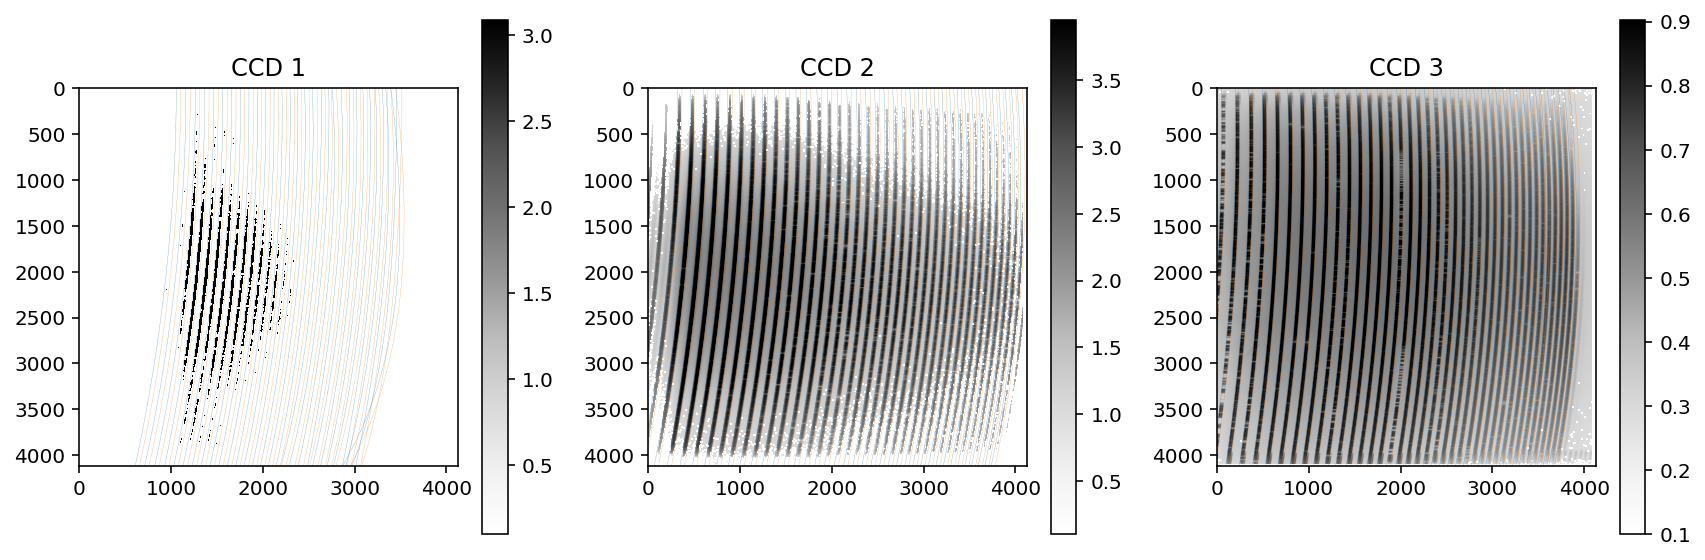

  -> Successfully extracted HIP69673


In [7]:
# Extract Science Objects and save them into FITS files under reduced_data/
for science_object in list(science_runs.keys()):
    print('Extracting '+science_object)
    try:
        science, science_noise, science_header = VR.extraction.extract_orders(
            ccd1_runs = science_runs[science_object],
            ccd2_runs = science_runs[science_object],
            ccd3_runs = science_runs[science_object],
            Science=True,
            master_darks = master_darks, # These are needed to subtract the dark current
            debug_tramlines = True, # Would create a tramlines trace PDF under
            # reduced_data/YYMMDD/debug/debug_tramlines_{metadata['OBJECT']}.pdf
            debug_overscan=False
        )

        # Create a primary HDU and HDU list
        primary_hdu = fits.PrimaryHDU()
        header = primary_hdu.header
        header['OBJECT']             = (science_header['OBJECT'], 'Name of observed object in night log')
        header['HIERARCH SOURCE_ID'] = (-1,                       'Gaia DR3 source_id')
        header['HIERARCH TMASS_ID']  = ('HHMMSSSS-DDMMSSS',       'Identifier in 2MASS catalog')
        header['UTMJD']              = (science_header['UTMJD'],  'Modified Julian Date of observation')
        header['MEANRA']             = (science_header['MEANRA'], 'Mean Right Ascension of observed object')
        header['MEANDEC']            = (science_header['MEANDEC'],'Mean Declination of observed object')        
        header['BARYVEL']            = ('None',                   'Applied barycentric velocity correction')
        header['VRAD']               = ('None',                   'Radial velocity estimate')
        header['E_VRAD']             = ('None',                   'Uncertainty of radial velocity estimate')
        hdul = fits.HDUList([primary_hdu])

        # Extract order ranges and coefficients
        order_ranges, order_beginning_coeffs, order_ending_coeffs = VR.extraction.read_in_order_tramlines()

        # Loop over your extension names and corresponding data arrays
        for ext_index, ext_name in enumerate(order_beginning_coeffs):
            # Create an ImageHDU object for each extension
            
            # Apply flat-field calibration to science
            science[ext_index,:] /= master_flat[ext_index,:]
            science_noise[ext_index,:] /= master_flat[ext_index,:]
            
            # Apply rough renormalisation with outlier-robuster 90th percenile of ~middle of order
            science_90percentile = np.nanpercentile(science[ext_index,1500:2500],q=90)
            science[ext_index,:] /= science_90percentile
            science_noise[ext_index,:] /= science_90percentile
            
            # Define the columns with appropriate formats
            col1_def = fits.Column(name='wave_vac',format='E', array=np.arange(len(science[ext_index,:]),dtype=float))
            col2_def = fits.Column(name='wave_air',format='E', array=np.arange(len(science[ext_index,:]),dtype=float))
            col3_def = fits.Column(name='science', format='E', array=science[ext_index,:])
            col4_def = fits.Column(name='science_noise',   format='E', array=science_noise[ext_index,:])
            col5_def = fits.Column(name='flat',    format='E', array=master_flat[ext_index,:])
            col6_def = fits.Column(name='thxe',    format='E', array=master_thxe[ext_index,:]/master_flat[ext_index,:])
            col7_def = fits.Column(name='lc',      format='E', array=master_lc[ext_index,:]/master_flat[ext_index,:])

            # Combine columns to BinTable and add header from primary
            hdu = fits.BinTableHDU.from_columns([col1_def, col2_def, col3_def, col4_def, col5_def, col6_def, col7_def], name=ext_name.lower())
            hdu.header.extend(header.copy(strip=True), unique=True)
    
            # Append the HDU to the HDU list
            hdul.append(hdu)

        # Save to a new FITS file with an extension for each order
        Path(config.working_directory+'reduced_data/'+config.date+'/'+science_object).mkdir(parents=True, exist_ok=True)
        spectrum_filename = 'veloce_spectra_'+science_object+'_'+config.date+'.fits'
        hdul.writeto(config.working_directory+'reduced_data/'+config.date+'/'+science_object+'/'+spectrum_filename, overwrite=True)

        print('  -> Successfully extracted '+science_object)

    except:
        print('  -> Failed to extract '+science_object)

## Wavelength calibration

Calibrating wavelength for HIP69673
  -> Correcting for barycentric velocity: -21.07 km/s
  -> Using previous LC and ThXe calibrations as wavelength solution
  -> Estimating rough RV from Halpha and CaT; starting with CaII 8662 using its RV as initial guess for others.
  -> Fitting Halpha, but neglecting for RV estimate.
  -> No RV outlier(s) identified.
  -> $v_\mathrm{rad}  = -5.19 \pm 0.45 \pm 1.52\,\mathrm{km\,s^{-1}}$ (mean, scatter, unc.) based on 8 lines.


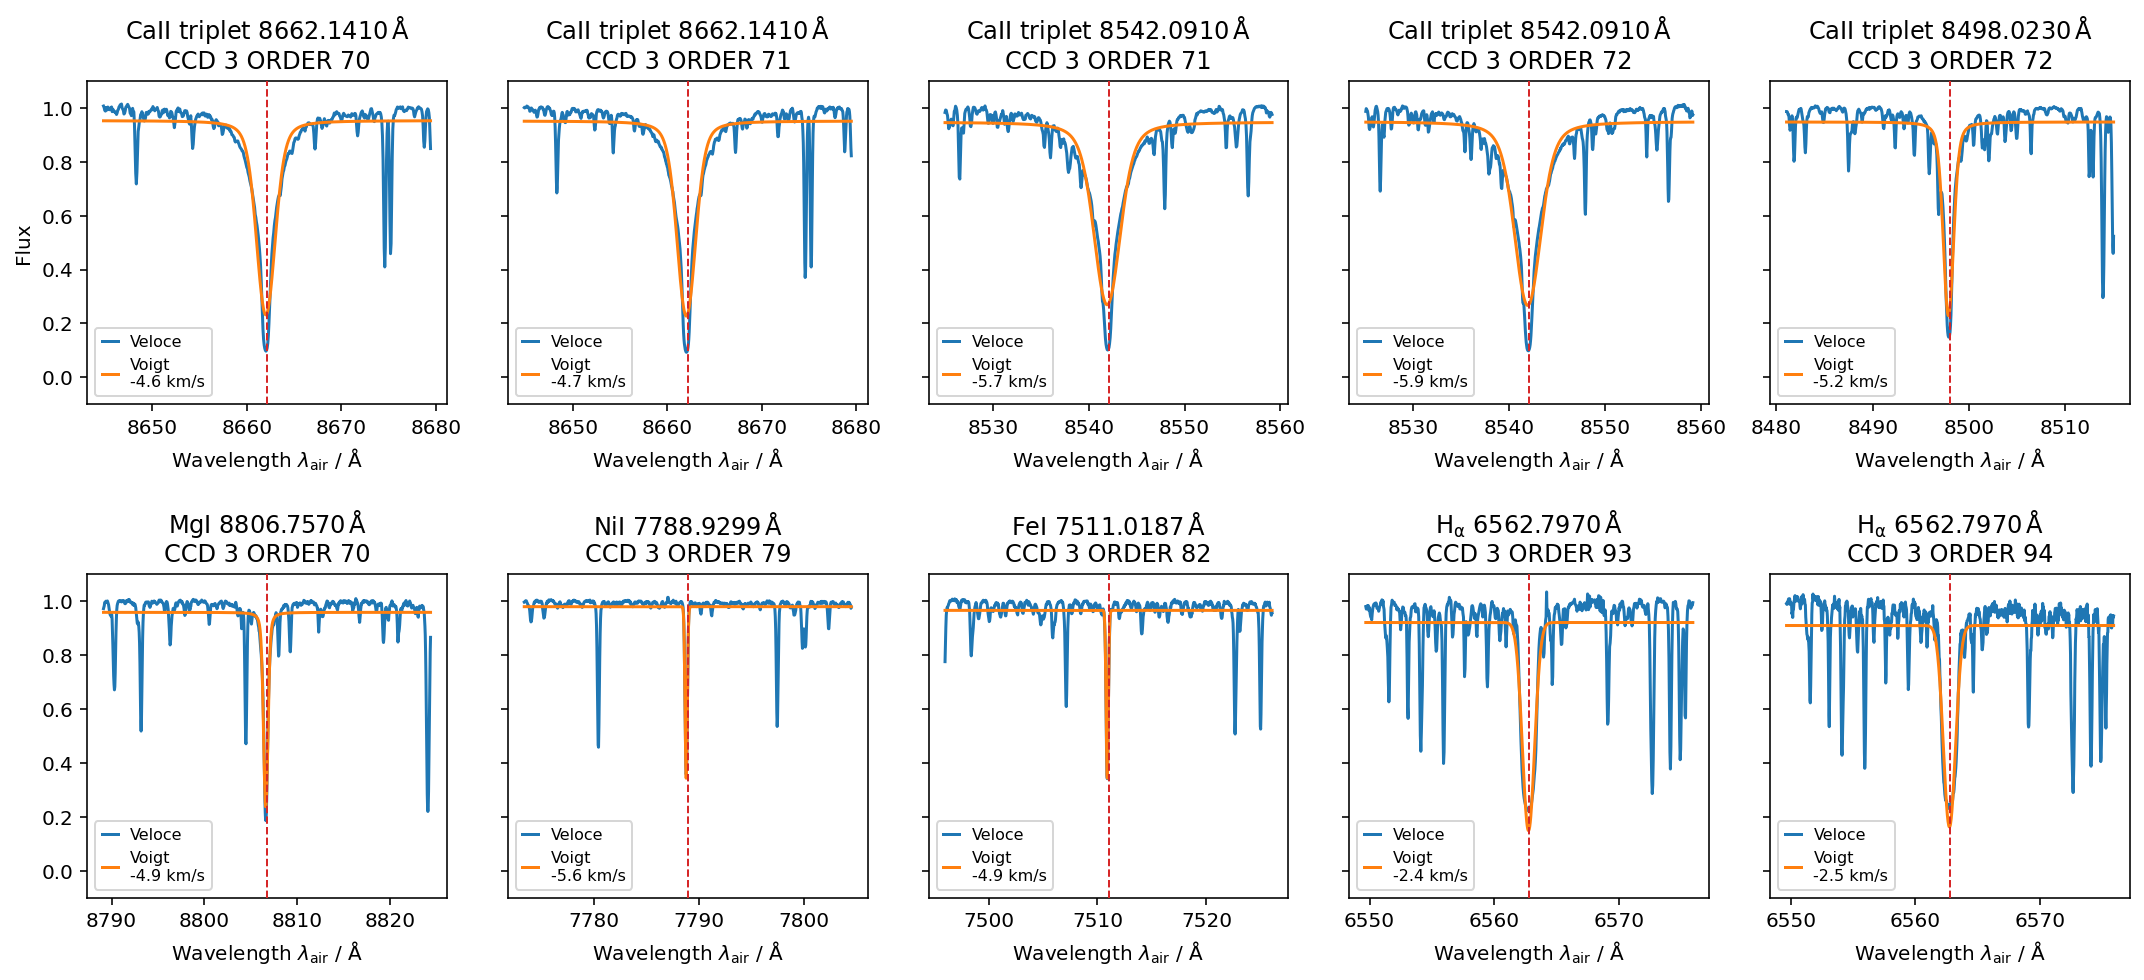

  -> Creating overview PDF. This may take some time for the 109 orders.

  -> Succesfully calibrated wavelength with diagnostic plots for HIP69673



In [8]:
for science_object in list(science_runs.keys()):
    try:
        VR.calibration.calibrate_wavelength(
            science_object,
            optimise_lc_solution=False,
            correct_barycentric_velocity=True,
            create_overview_pdf=True
        )
        print('  -> Succesfully calibrated wavelength with diagnostic plots for '+science_object+'\n')
    except:
        print('  -> Failed to calibrate wavelength for '+science_object+'\n')

In [9]:
# import VeloceReduction as VR
# from astropy.io import fits

# korg_spectra = VR.flux_comparison.read_korg_syntheses()

# with fits.open('reduced_data/250111/HIP47908/veloce_spectra_HIP47908_250111.fits') as veloce_fits_file:
    
#     VR.flux_comparison.calculate_wavelength_coefficients_with_korg_synthesis(
#         veloce_fits_file,
#         korg_wavelength_vac = korg_spectra['wavelength_vac'],
#         korg_flux = korg_spectra['flux_arcturus'],
#         order_selection=['ccd_3_order_70','ccd_3_order_71'],
#         debug=False
#     )

## Monitor RV (for stars with multiple observations and seperate reductions)

In [10]:
repeated_observations = VR.utils.check_repeated_observations(science_runs)

VR.utils.monitor_vrad_for_repeat_observations(config.date, repeated_observations)

No repeated observations found.


## Final Memory Check

In [11]:
print('Memory before starting the reduction was:')
print(starting_memory)
print('Memory after running the reduction is:')
print(get_memory_usage())

Memory before starting the reduction was:
Run on Apple/Darwin: 1097.1MB
Memory after running the reduction is:
Run on Apple/Darwin: 17.4MB
